In [1]:
import glob
import os
import random

from ficus import FigureManager, SubFigureManager
import ijson
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from numerize import numerize

In [78]:
pd.set_option('display.max_columns', 500)

In [2]:
random.seed(42)

In [3]:
@mpl.ticker.FuncFormatter
def numerize_fmtr(x, pos):
    return numerize.numerize(x)

In [4]:
def despine(*args, **kwargs):
    for ax in args:
        sns.despine(ax=ax, offset=10, trim=True, **kwargs)
        ax.yaxis.grid(ls='--')

In [32]:
meta = pd.read_csv('../config/chap1-txomes.csv', index_col='sample_accession', comment='#')

## Results: Download Datarate Figure

In [5]:
files = sorted(glob.glob('../results/chap1/SAM*.curl.txt'))
samples = set([os.path.basename(f).split('.')[0] for f in files])

In [6]:
def get_diffs(df):
    return pd.DataFrame({'d_t': df['elapsed_s'][1:].values - df['elapsed_s'][:-1].values,
                         'd_bytes': df['bytes_read'][1:].values - df['bytes_read'][:-1].values,
                         't': df['elapsed_s'][1:]})

In [7]:
stream_df = []
for accession in samples:
    print(f'Reading {accession}...')
    left_fn = f'../results/chap1/{accession}.1.curl.txt'
    right_fn = f'../results/chap1/{accession}.2.curl.txt'
    ldf = get_diffs(pd.read_table(left_fn, delim_whitespace=True, names=['elapsed_s', 'bytes_read']))
    rdf = get_diffs(pd.read_table(right_fn, delim_whitespace=True, names=['elapsed_s', 'bytes_read']))
    
    bins = list(range(0, int(max(ldf.t.max(), rdf.t.max())), 5))
    
    ldf = ldf.groupby(pd.cut(ldf.t, labels=bins[1:], bins=bins)).mean()
    ldf['bytes/s'] = ldf.d_bytes / ldf.d_t
    rdf = rdf.groupby(pd.cut(rdf.t, labels=bins[1:], bins=bins)).mean()
    rdf['bytes/s'] = rdf.d_bytes / rdf.d_t
    
    df = pd.DataFrame({'t': ldf.index,
                       'bytes/s': ldf['bytes/s'] + rdf['bytes/s'],
                       'accession': accession})
    df['MiB/s'] = df['bytes/s'] / 1048576

    stream_df.append(df.copy())
stream_df = pd.concat(stream_df).reset_index(drop=True)

Reading SAMN10236109...
Reading SAMN04576178...
Reading SAMN08038114...
Reading SAMEA3176945...
Reading SAMEA2747216...
Reading SAMEA104703328...
Reading SAMEA4064425...
Reading SAMN03002991...
Reading SAMEA6498954...
Reading SAMN03493070...
Reading SAMN10236070...
Reading SAMN04349088...
Reading SAMN09378356...
Reading SAMN05991912...
Reading SAMN10520155...
Reading SAMN09758735...
Reading SAMEA4774291...
Reading SAMN04088456...
Reading SAMN10537738...
Reading SAMEA103927134...
Reading SAMEA3894957...
Reading SAMN04126864...
Reading SAMEA4791499...


In [8]:
stream_df.head()

,t,bytes/s,accession,MiB/s
0,5,0.000000e+00,SAMN10236109,0.000000
1,10,0.000000e+00,SAMN10236109,0.000000
2,15,6.526468e+05,SAMN10236109,0.622412
3,20,2.019186e+06,SAMN10236109,1.925646
4,25,2.064723e+06,SAMN10236109,1.969073


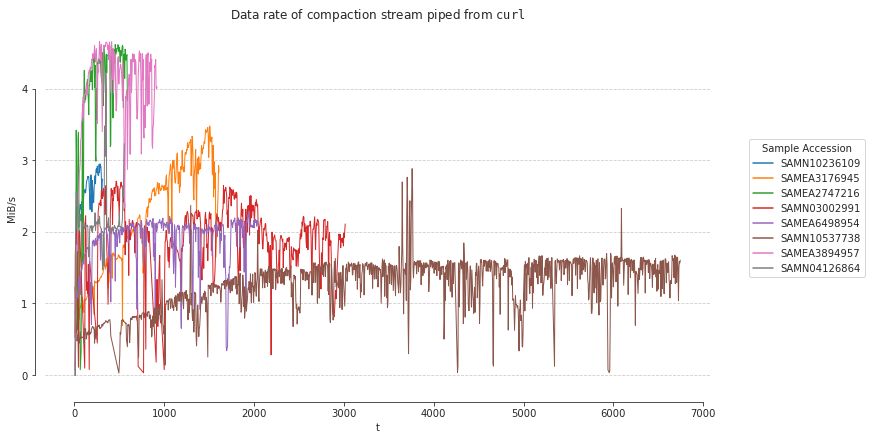

In [9]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, figsize=(12,6)) as (fig, ax):
    
    random.seed(42)
    subsampled = random.sample(list(stream_df.accession.unique()), 8)
    
    
    sns.lineplot(data=stream_df[stream_df['accession'].isin(subsampled)], 
                 x='t', y='MiB/s', hue='accession', lw=1, legend=True, ax=ax)
    ax.set_title('Data rate of compaction stream piped from $\mathtt{curl}$')
    ax.legend(bbox_to_anchor=(1.05, .5), loc='center left', title='Sample Accession')
    sns.despine(fig=fig, offset=10, trim=True)
    ax.yaxis.grid(ls='--')

## Results: Decision Nodes Figure

In [10]:
def normalize_metrics(data):
    data['t_norm'] = data['t'] / data['t'].max()

    cdbg_cols =['n_full', 'n_tips', 'n_islands', 'n_trivial', 'n_circular']
    for col in cdbg_cols:
        data[col + '_p'] = data[col] / data['n_unodes']
    data['dnode_p'] = data['n_dnodes'] / (data['n_unodes'] + data['n_dnodes'])
    data['kmer_p'] = data['n_unique_kmers'] / data['n_unique_kmers'].max()
    prop_cols = [col + '_p' for col in cdbg_cols] + [ 'kmer_p']
    
    return data, prop_cols

In [11]:
def get_cdbg_build_metrics():

    files = sorted(glob.glob('../results/chap1/cdbg-build/*/goetia.cdbg.stats.json'))
    samples = set([f.split('/')[4] for f in files])
    
    metrics_df = []
    for f in files:
        print(f)
        try:
            df = pd.read_json(f)
            df, prop_cols = normalize_metrics(df)
        except ValueError:
            pass
        else:
            #df['t_norm'] = df['t'] / df['t'].max()
            metrics_df.append(df)
    metrics_df = pd.concat(metrics_df).reset_index(drop=True)
    
    return metrics_df
#metrics_df['sample_name'] = metrics_df.sample_name.str.rpartition('.')[0]

In [12]:
cdbg_metrics_df = get_cdbg_build_metrics()

../results/chap1/cdbg-build/SAMEA103927134/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA2747216/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA4791499/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA6498954/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN03002991/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN03493070/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN04349088/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN04576178/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN05991912/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN08038114/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN09378356/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN09758735/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN10236070/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN10236109/goetia.cdbg.stats.json


In [13]:
cdbg_metrics_df.head()

,t,seq_t,rt_elapsed_interval,rt_elapsed_total,sample_name,n_full,n_tips,n_islands,n_trivial,n_circular,...,n_unique_kmers,estimated_fp,t_norm,n_full_p,n_tips_p,n_islands_p,n_trivial_p,n_circular_p,dnode_p,kmer_p
0,500175,5265,1.147900,1.148162,SAMEA103927134,1265,1261,2899,287,1,...,362885,0,0.001320,0.221309,0.220609,0.507173,0.050210,0.000175,0.253883,0.006063
1,1000350,10530,0.296973,1.445202,SAMEA103927134,2339,2431,4968,555,1,...,639801,0,0.002639,0.227109,0.236042,0.482377,0.053889,0.000097,0.265511,0.010690
2,1500430,15794,0.327589,1.772852,SAMEA103927134,3487,3651,7091,813,1,...,930948,0,0.003958,0.231710,0.242607,0.471194,0.054024,0.000066,0.269608,0.015554
3,2000605,21059,0.285903,2.058810,SAMEA103927134,4692,4930,8878,1081,0,...,1192726,0,0.005278,0.239571,0.251723,0.453306,0.055195,0.000000,0.278212,0.019928
4,2500685,26323,0.275885,2.334749,SAMEA103927134,5911,6247,10626,1306,0,...,1455688,0,0.006597,0.245331,0.259276,0.441023,0.054204,0.000000,0.284025,0.024321


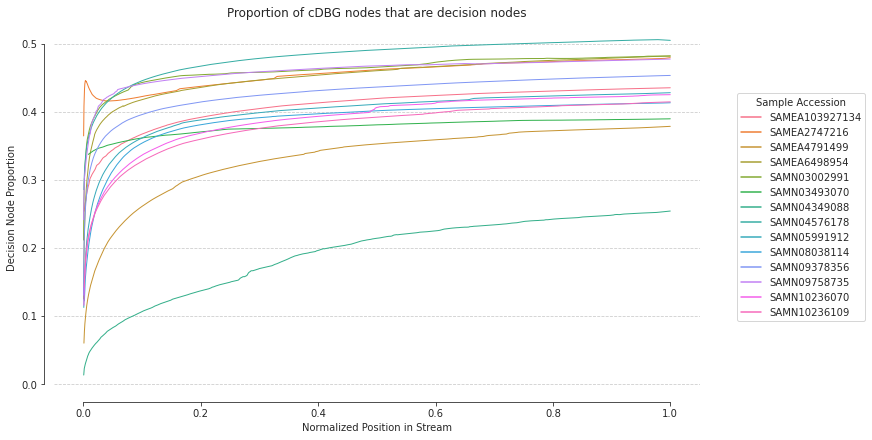

In [14]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, figsize=(12,6)) as (fig, ax):
    
    sns.lineplot(data=cdbg_metrics_df, x='t_norm', y='dnode_p', hue='sample_name', lw=1, ax=ax)
    ax.set_ylabel('Decision Node Proportion')
    ax.set_xlabel('Normalized Position in Stream')
    ax.legend(bbox_to_anchor=(1.05, .5), loc='center left', title='Sample Accession')
    ax.set_title('Proportion of cDBG nodes that are decision nodes')
    
    sns.despine(fig=fig, offset=10, trim=True)
    ax.yaxis.grid(ls='--')

In [ ]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, figsize=(12,len(files) * 2), tight_layout=True, nrows=len(files)//2, ncols=2) as (fig, axs):
    
    from matplotlib.lines import Line2D
    
    for i, sample_name in enumerate(comps_df.sample_name.unique()):
        ax = axs[i // 2, i % 2]
    
        #mdf = comps_df.query('sample_name == "SAMN09758735"')
        mdf = comps_df.query(f'sample_name == "{sample_name}"')
        #df = mdf.reset_index().melt(value_vars=['min', 'max', 'n_components'], id_vars=['sample_name', 't'])
        g = sns.lineplot(data=mdf, x='t_norm', y='n_components', lw=2, color=sns.color_palette()[0], ax=ax)
        sax = g.axes.twinx()
        sns.lineplot(data=mdf, x='t_norm', y='max', lw=2, color=sns.color_palette()[1], ax=sax)
        ax.set_ylabel('Components')
        ax.set_xlabel('Normalized Position in Stream')
        ax.set_title(sample_name)
        sax.set_ylabel('Max Component Size')

        g.legend(handles=[Line2D([], [], marker='_', color=sns.color_palette()[0], label='Components'), 
                          Line2D([], [], marker='_', color=sns.color_palette()[1], label='Max Component Size')],
                loc='lower right')
        sns.despine(ax=ax, offset=10, trim=True, right=False)
        sns.despine(ax=sax, offset=10, trim=True, right=False)
        ax.yaxis.grid(ls='--')

In [394]:
metrics_df

,t,seq_t,rt_elapsed_interval,rt_elapsed_total,sample_name,n_full,n_tips,n_islands,n_trivial,n_circular,...,n_unique_kmers,estimated_fp,t_norm,n_full_p,n_tips_p,n_islands_p,n_trivial_p,n_circular_p,dnode_p,kmer_p
0,5000135,52633,13.163505,13.163891,SAMEA103927134,12478,13035,18413,2689,0,...,2681613,0,0.013191,0.267642,0.279589,0.394942,0.057677,0.000000e+00,0.305259,0.044804
1,10000270,105266,2.931621,16.095590,SAMEA103927134,25583,26472,29874,5272,0,...,4795154,0,0.026383,0.293322,0.303515,0.342521,0.060446,0.000000e+00,0.323797,0.080116
2,15000310,157898,2.693477,18.789150,SAMEA103927134,39357,40320,38539,8072,1,...,6673528,0,0.039574,0.311576,0.319199,0.305100,0.063903,7.916653e-06,0.336241,0.111500
3,20000350,210530,2.891793,21.681015,SAMEA103927134,54170,54556,44781,11046,2,...,8348020,0,0.052765,0.329127,0.331472,0.272081,0.067113,1.215163e-05,0.346137,0.139477
4,25000485,263163,2.721536,24.402633,SAMEA103927134,69029,67612,49965,14215,2,...,9888165,0,0.065956,0.343671,0.336616,0.248758,0.070771,9.957283e-06,0.353252,0.165209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16213,11920341620,98515220,2.137545,6739.288705,SAMN10537738,56464404,23184669,629456,11333556,18,...,1512157621,0,0.998332,0.616340,0.253073,0.006871,0.123712,1.964799e-07,0.443062,0.998999
16214,11925341703,98556543,2.114395,6741.403166,SAMN10537738,56476940,23192200,629641,11337935,18,...,1512512224,0,0.998751,0.616311,0.253088,0.006871,0.123727,1.964271e-07,0.443070,0.999233
16215,11930341907,98597867,2.088531,6743.491762,SAMN10537738,56489225,23199304,629799,11342375,18,...,1512847019,0,0.999170,0.616284,0.253099,0.006871,0.123743,1.963757e-07,0.443078,0.999454
16216,11935341990,98639190,2.108276,6745.600104,SAMN10537738,56501960,23206956,629992,11347065,18,...,1513212370,0,0.999589,0.616253,0.253113,0.006871,0.123760,1.963216e-07,0.443086,0.999695


## Results: Component Distribution Figure

In [15]:
def parse_components_metrics(fp):
    backend = ijson.get_backend('yajl2')
    metrics = []
    #sizes = []
    for row in backend.items(fp, 'item'):
        metrics.append({k: row[k] for k in set(row.keys()) - set(('sizes',))})
        #sizes.append(sorted(row['sizes']))
    metrics_df = pd.DataFrame(metrics)
    #sizes_df = pd.DataFrame(sizes, index=metrics_df.index)
    return metrics_df

In [16]:
def get_cdbg_comps_df():
    files = sorted(glob.glob('../results/chap1/cdbg-build/*/goetia.cdbg.components.json'))
    
    comps_df = []
    for f in files:
        print(f)
        try:
            with open(f) as fp:
                mdf = parse_components_metrics(fp)
                mdf['t_norm'] = mdf['t'] / mdf['t'].max()
                comps_df.append(mdf)
        except ijson.IncompleteJSONError:
            print(f'JSON error in {f}')
            pass
    comps_df = pd.concat(comps_df).reset_index(drop=True)
    comps_df['log_n_components'] = np.log(comps_df['n_components'])
    return comps_df
#comps_df['sample_name'] = metrics_df.sample_name.str.rpartition('.')[0]

In [26]:
comps_df = get_cdbg_comps_df()

../results/chap1/cdbg-build/SAMEA103927134/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMEA2747216/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMEA4791499/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMEA6498954/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN03002991/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN03493070/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN04349088/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN04576178/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN05991912/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN08038114/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN09378356/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN09758735/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN10236070/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAMN10236109/goetia.cdbg.components.json


In [27]:
comps_df

,max,sample_name,min,t,n_components,t_norm,log_n_components
0,190889,SAMEA103927134,1,25005805,58610,0.066667,10.978661
1,399496,SAMEA103927134,1,50011135,80423,0.133333,11.295055
2,623399,SAMEA103927134,1,75016655,91303,0.200000,11.421939
3,843697,SAMEA103927134,1,100021700,96804,0.266665,11.480444
4,1074223,SAMEA103927134,1,125027030,99444,0.333331,11.507350
...,...,...,...,...,...,...,...
847,4248257,SAMN10236109,1,505034999,234642,0.723495,12.365816
848,4579344,SAMN10236109,1,548038137,239545,0.785099,12.386497
849,4949490,SAMN10236109,1,594041522,247367,0.851002,12.418628
850,5340729,SAMN10236109,1,644045118,256749,0.922636,12.455854


In [376]:
#mdf.reset_index().melt(value_vars=['min', 'max', 'n_components'], id_vars=['sample_name', 't'])

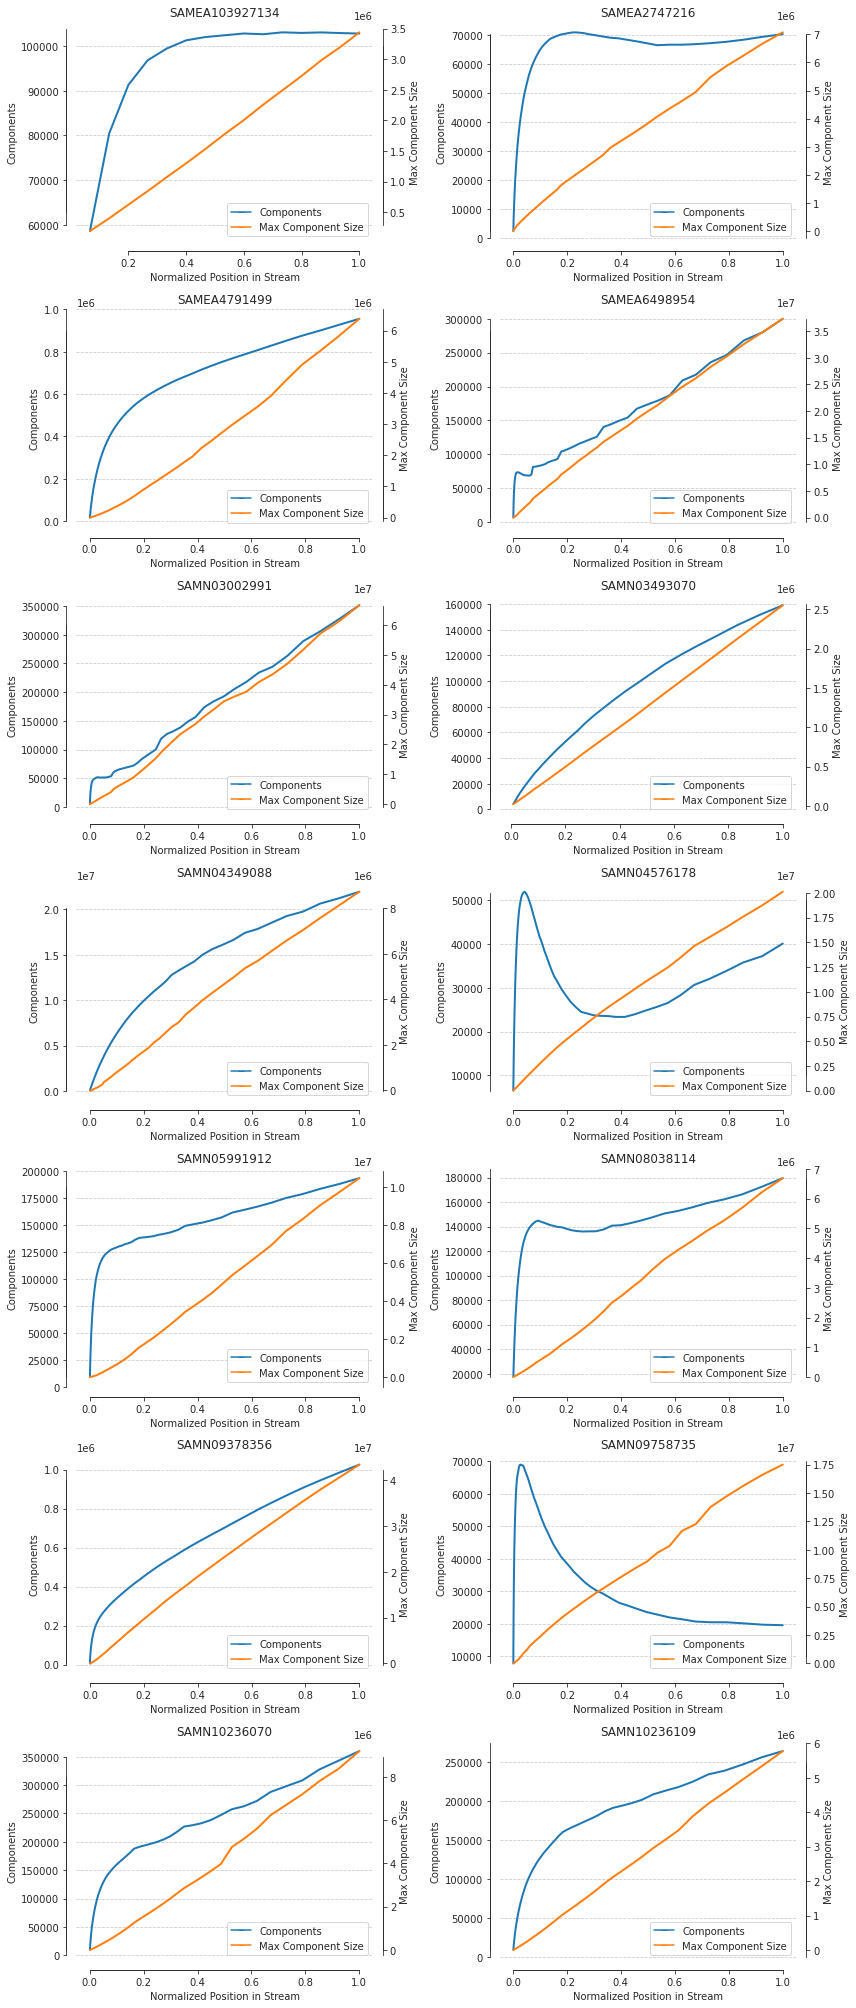

In [28]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, figsize=(12,len(files) * 2), tight_layout=True, nrows=len(files)//2, ncols=2) as (fig, axs):
    
    from matplotlib.lines import Line2D
    
    for i, sample_name in enumerate(comps_df.sample_name.unique()):
        ax = axs[i // 2, i % 2]
    
        #mdf = comps_df.query('sample_name == "SAMN09758735"')
        mdf = comps_df.query(f'sample_name == "{sample_name}"')
        #df = mdf.reset_index().melt(value_vars=['min', 'max', 'n_components'], id_vars=['sample_name', 't'])
        g = sns.lineplot(data=mdf, x='t_norm', y='n_components', lw=2, color=sns.color_palette()[0], ax=ax)
        sax = g.axes.twinx()
        sns.lineplot(data=mdf, x='t_norm', y='max', lw=2, color=sns.color_palette()[1], ax=sax)
        ax.set_ylabel('Components')
        ax.set_xlabel('Normalized Position in Stream')
        ax.set_title(sample_name)
        sax.set_ylabel('Max Component Size')

        g.legend(handles=[Line2D([], [], marker='_', color=sns.color_palette()[0], label='Components'), 
                          Line2D([], [], marker='_', color=sns.color_palette()[1], label='Max Component Size')],
                loc='lower right')
        sns.despine(ax=ax, offset=10, trim=True, right=False)
        sns.despine(ax=sax, offset=10, trim=True, right=False)
        ax.yaxis.grid(ls='--')


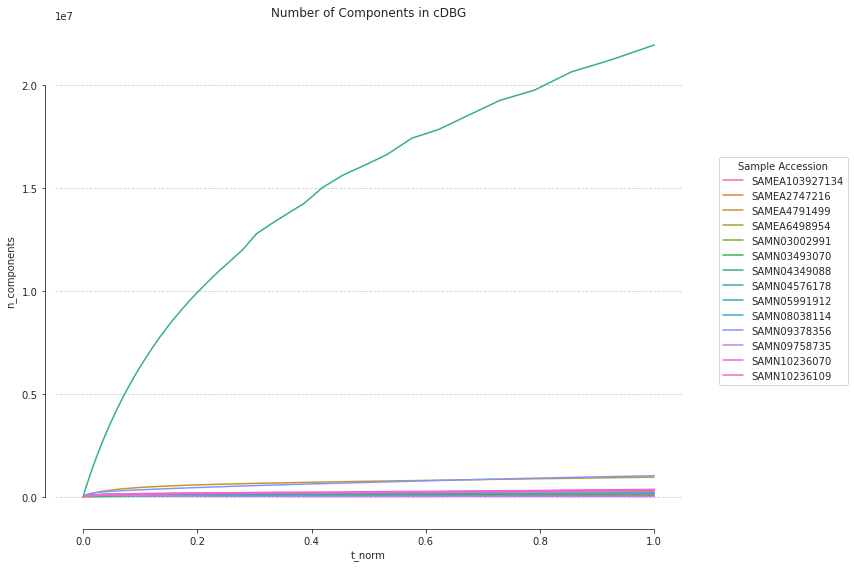

In [29]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, tight_layout=True, figsize=(12,8)) as (fig, ax):
    
    sns.lineplot(data=comps_df, x='t_norm', y='n_components',  hue='sample_name', lw=1.5, ax=ax)
    ax.legend(bbox_to_anchor=(1.05, .5), loc='center left', title='Sample Accession')
    ax.set_title('Number of Components in cDBG')
    
    sns.despine(fig=fig, offset=10, trim=True)
    ax.yaxis.grid(ls='--')

## Results: Unitig Fragmentation Figure

In [17]:
def get_cdbg_frag_df():
    files = sorted(glob.glob('../results/chap1/cdbg-build/*/goetia.cdbg.unitigs.bp.json'))
    
    frag_df = []
    for f in files:
        print(f)
        try:
            fdf = pd.read_json(f)
            fdf['t_norm'] = fdf['t'] / fdf['t'].max()
            frag_df.append(fdf)
        except ValueError:
            pass
    frag_df = pd.concat(frag_df).reset_index(drop=True)
    return frag_df

In [18]:
frag_df = get_cdbg_frag_df()

../results/chap1/cdbg-build/SAMEA103927134/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMEA2747216/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMEA4791499/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMEA6498954/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN03002991/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN03493070/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN04349088/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN04576178/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN05991912/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN08038114/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN09378356/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN09758735/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN10236070/goetia.cdbg.unitigs.bp.json
../results/chap1/cdbg-build/SAMN10236109/goetia.cdbg.unitigs.bp.json


In [19]:
frag_df = frag_df.melt(id_vars=['sample_name', 't', 't_norm'], var_name='Unitig Length Bin')

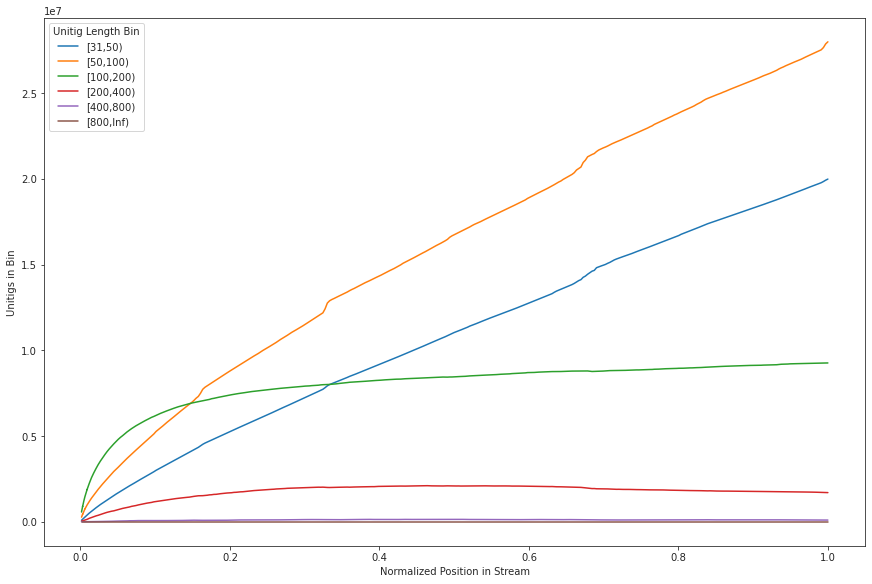

In [20]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, figsize=(12,8)) as (fig, ax):
    
    df = frag_df.query('sample_name == "SAMEA2747216"')
    sns.lineplot(data=df, x='t_norm', y='value',  hue='Unitig Length Bin', ax=ax)
    ax.set_xlabel('Normalized Position in Stream')
    ax.set_ylabel('Unitigs in Bin')

## Results: Datarate Comparisons

In [21]:
def calc_rates(df):
    return pd.DataFrame({'kmers/s': (df['t'].values[1:] - df['t'].values[:-1]) / df['rt_elapsed_interval'].values[1:],
                         'seqs/s': (df['seq_t'].values[1:] - df['seq_t'].values[:-1]) / df['rt_elapsed_interval'].values[1:],
                         't': df['t'].values[1:],
                         'sample_name': df['sample_name'].values[1:],
                         't_norm': df['t_norm'].values[1:],
                         'rt_elapsed_total': df['rt_elapsed_total'][1:]})

In [22]:
def read_metrics_files(files):
    metrics_df = []
    for f in files:
        print(f)
        try:
            df = pd.read_json(f)
        except ValueError as e:
            print(f'Error reading {f}: {e}')
            pass
        else:
            df['t_norm'] = df['t'] / df['t'].max()
            metrics_df.append(calc_rates(df))
    metrics_df = pd.concat(metrics_df).reset_index(drop=True)
    return metrics_df

In [23]:
cdbg_metrics_files =  sorted(glob.glob('../results/chap1/cdbg-build/*/goetia.cdbg.stats.json'))
dbg_baseline_files = sorted(glob.glob('../results/chap1/dbg-stream-baseline/*/metrics.json'))
hash_baseline_files = sorted(glob.glob('../results/chap1/hash-stream-baseline/*/metrics.json'))

In [24]:
cdbg_metrics = read_metrics_files(cdbg_metrics_files)
dbg_metrics = read_metrics_files(dbg_baseline_files)
hash_metrics = read_metrics_files(hash_baseline_files)

../results/chap1/cdbg-build/SAMEA103927134/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA2747216/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA4791499/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA6498954/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN03002991/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN03493070/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN04349088/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN04576178/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN05991912/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN08038114/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN09378356/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN09758735/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN10236070/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN10236109/goetia.cdbg.stats.json
../results/chap1/dbg-stream-baseline/SAMEA103927134/metrics.json
../results/chap1/dbg-stream-baseline/

In [25]:
hash_metrics['operation'] = 'hash'
dbg_metrics['operation'] = 'dbg'
cdbg_metrics['operation'] = 'cdbg'

In [26]:
rates_df = pd.concat((hash_metrics, dbg_metrics, cdbg_metrics))

In [27]:
rates_df.head()

,kmers/s,seqs/s,t,sample_name,t_norm,rt_elapsed_total,operation
0,6.084570e+07,640481.029462,2000225,SAMEA103927134,0.005277,0.327774,hash
1,5.560891e+07,585356.947196,3000385,SAMEA103927134,0.007916,0.345805,hash
2,5.326101e+07,560642.233565,4000545,SAMEA103927134,0.010554,0.364626,hash
3,5.553823e+07,584612.918943,5000705,SAMEA103927134,0.013193,0.382679,hash
4,5.598629e+07,589329.326414,6000770,SAMEA103927134,0.015831,0.400585,hash


In [28]:
rates_df.groupby(['sample_name', 'operation']).mean().reset_index()

,sample_name,operation,kmers/s,seqs/s,t,t_norm,rt_elapsed_total
0,SAMEA103927134,cdbg,2.474837e+06,2.605092e+04,1.900419e+08,0.501365,106.865749
1,SAMEA103927134,dbg,8.081181e+06,8.506507e+04,1.910203e+08,0.503946,25.291056
2,SAMEA103927134,hash,5.511239e+07,5.801304e+05,1.910203e+08,0.503946,3.760407
3,SAMEA2747216,cdbg,6.066860e+06,8.544873e+04,1.685617e+09,0.500436,380.228709
4,SAMEA2747216,dbg,1.369843e+07,1.929357e+05,1.685617e+09,0.500436,123.388232
5,SAMEA2747216,hash,4.883298e+07,6.877885e+05,1.685617e+09,0.500436,34.783834
6,SAMEA4791499,cdbg,2.288007e+06,5.084459e+04,6.230368e+08,0.501101,384.717163
7,SAMEA4791499,dbg,6.566236e+06,1.459164e+05,6.230368e+08,0.501101,101.360832
8,SAMEA4791499,hash,3.839249e+07,8.531665e+05,6.230368e+08,0.501101,16.597236
9,SAMEA6498954,cdbg,2.760594e+06,2.380043e+04,2.759820e+09,0.500250,1528.664185


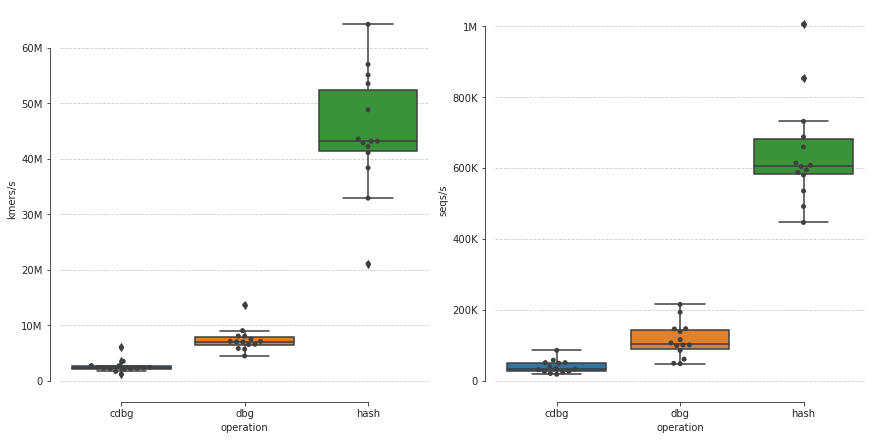

In [29]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, ncols=2, figsize=(12,6)) as (fig, axs):
    
    mean_rates = data=rates_df.groupby(['sample_name', 'operation']).mean().reset_index()
    sns.boxplot(x='operation', y='kmers/s', data=mean_rates, ax=axs[0])
    sns.swarmplot(x='operation', y='kmers/s', data=mean_rates, color=".25", ax=axs[0])
    
    sns.boxplot(x='operation', y='seqs/s', data=mean_rates, ax=axs[1])
    sns.swarmplot(x='operation', y='seqs/s', data=mean_rates, color=".25", ax=axs[1])
    
    #ax.legend(bbox_to_anchor=(1.05, .5), loc='center left', title='Sample Accession')
    #ax.set_title('Number of Components in cDBG')
    
    sns.despine(ax=axs[0], offset=10, trim=True)
    axs[0].yaxis.grid(ls='--')
    axs[0].yaxis.set_major_formatter(numerize_fmtr)
    
    sns.despine(ax=axs[1], offset=10, trim=True)
    axs[1].yaxis.grid(ls='--')
    axs[1].yaxis.set_major_formatter(numerize_fmtr)

## Results: Solid cDBG Figure

In [66]:
def get_solid_cdbg_build_metrics():

    files = sorted(glob.glob('../results/chap1/solid-cdbg-build/*/goetia.cdbg.stats.json'))
    samples = set([f.split('/')[4] for f in files])
    
    metrics_df = []
    for f in files:
        print(f)
        try:
            df = pd.read_json(f)
            df, prop_cols = normalize_metrics(df)
        except ValueError:
            pass
        else:
            df['t_norm'] = df['t'] / df['t'].max()
            metrics_df.append(df)
    metrics_df = pd.concat(metrics_df).reset_index(drop=True)
    metrics_df['sample_name'] = metrics_df['sample_name'].str.partition('.')[0]
    
    return metrics_df

In [67]:
def get_solid_cdbg_comps_df():
    files = sorted(glob.glob('../results/chap1/solid-cdbg-build/*/goetia.cdbg.components.json'))
    
    comps_df = []
    for f in files:
        print(f)
        try:
            with open(f) as fp:
                mdf = parse_components_metrics(fp)
                mdf['t_norm'] = mdf['t'] / mdf['t'].max()
                comps_df.append(mdf)
        except ijson.IncompleteJSONError:
            print(f'JSON error in {f}')
            pass
    comps_df = pd.concat(comps_df).reset_index(drop=True)
    comps_df['log_n_components'] = np.log(comps_df['n_components'])
    comps_df['sample_name'] = comps_df['sample_name'].str.partition('.')[0]
    return comps_df

In [68]:
raw_cdbg_metrics_df = get_cdbg_build_metrics()
raw_comps_df = get_cdbg_comps_df()

solid_cdbg_metrics_df = get_solid_cdbg_build_metrics()
solid_comps_df = get_solid_cdbg_comps_df()

../results/chap1/cdbg-build/SAMEA103927134/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA2747216/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA4791499/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA6498954/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN03002991/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN03493070/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN04349088/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN04576178/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN05991912/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN08038114/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN09378356/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN09758735/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN10236070/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMN10236109/goetia.cdbg.stats.json
../results/chap1/cdbg-build/SAMEA103927134/goetia.cdbg.components.json
../results/chap1/cdbg-build/SAM

In [69]:
raw_cdbg_metrics_df['prefilter'] = 'raw'
raw_comps_df['prefilter'] = 'raw'

solid_cdbg_metrics_df['prefilter'] = 'solid'
solid_comps_df['prefilter'] = 'solid'

prefilter_metrics_df = pd.concat((raw_cdbg_metrics_df, solid_cdbg_metrics_df)).reset_index(drop=True)
prefilter_comps_df = pd.concat((raw_comps_df, solid_comps_df)).reset_index(drop=True)

In [70]:
meta.query('scientific_name == "Saccharomyces cerevisiae"')

,Unnamed: 0,study_accession,secondary_sample_accession,experiment_accession,run_accession,tax_id,scientific_name,instrument_platform,instrument_model,library_layout,...,library_source,library_selection,read_count,base_count,fastq_ftp,sra_ftp,class_name,superkingdom_name,phylum_name,sample_read_count
sample_accession,,,,,,,,,,,,,,,,,,,,,
SAMN03002991,1764480,PRJNA250474,SRS842465,SRX872046,SRR1797370,4932,Saccharomyces cerevisiae,ILLUMINA,Illumina HiSeq 2000,PAIRED,...,TRANSCRIPTOMIC,RANDOM,23290864.0,6.987259e+09,ftp.sra.ebi.ac.uk/vol1/fastq/SRR179/000/SRR179...,ftp.sra.ebi.ac.uk/vol1/srr/SRR179/000/SRR1797370,Saccharomycetes,Eukaryota,Ascomycota,233972756.0
SAMN09758735,3506044,PRJNA484057,SRS3637820,SRX4519340,SRR7657722,4932,Saccharomyces cerevisiae,ILLUMINA,Illumina HiSeq 3000,PAIRED,...,TRANSCRIPTOMIC,RANDOM,33202649.0,6.640530e+09,ftp.sra.ebi.ac.uk/vol1/fastq/SRR765/002/SRR765...,ftp.sra.ebi.ac.uk/vol1/srr/SRR765/002/SRR7657722,Saccharomycetes,Eukaryota,Ascomycota,33202649.0
SAMEA2747216,1115813,PRJEB7178,ERS540020,ERX552477,ERR594530,4932,Saccharomyces cerevisiae,ILLUMINA,Illumina HiSeq 2000,PAIRED,...,TRANSCRIPTOMIC,RANDOM,23875870.0,4.822926e+09,ftp.sra.ebi.ac.uk/vol1/fastq/ERR594/ERR594530/...,ftp.sra.ebi.ac.uk/vol1/err/ERR594/ERR594530,Saccharomycetes,Eukaryota,Ascomycota,23875870.0


In [71]:
def sample_desc(sample_name, metadata, n_reads=None):
    sample_meta = metadata.loc[sample_name]
    species = ' '.join((f'$\it{{{w}}}$' for w in sample_meta.scientific_name.split()))
    n_reads = numerize.numerize(sample_meta.read_count) if n_reads is None else numerize.numerize(int(n_reads))
        
    return f'{species} ({sample_name}, {n_reads} {sample_meta.library_strategy} {sample_meta.library_selection} reads)'

In [72]:
prefilter_metrics_df

,t,seq_t,rt_elapsed_interval,rt_elapsed_total,sample_name,n_full,n_tips,n_islands,n_trivial,n_circular,...,estimated_fp,t_norm,n_full_p,n_tips_p,n_islands_p,n_trivial_p,n_circular_p,dnode_p,kmer_p,prefilter
0,500175,5265,1.147900,1.148162,SAMEA103927134,1265,1261,2899,287,1,...,0,0.001320,0.221309,0.220609,0.507173,0.050210,0.000175,0.253883,0.006063,raw
1,1000350,10530,0.296973,1.445202,SAMEA103927134,2339,2431,4968,555,1,...,0,0.002639,0.227109,0.236042,0.482377,0.053889,0.000097,0.265511,0.010690,raw
2,1500430,15794,0.327589,1.772852,SAMEA103927134,3487,3651,7091,813,1,...,0,0.003958,0.231710,0.242607,0.471194,0.054024,0.000066,0.269608,0.015554,raw
3,2000605,21059,0.285903,2.058810,SAMEA103927134,4692,4930,8878,1081,0,...,0,0.005278,0.239571,0.251723,0.453306,0.055195,0.000000,0.278212,0.019928,raw
4,2500685,26323,0.275885,2.334749,SAMEA103927134,5911,6247,10626,1306,0,...,0,0.006597,0.245331,0.259276,0.441023,0.054204,0.000000,0.284025,0.024321,raw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60927,594020790,8366490,0.293502,241.705412,SAMN10236109,556700,702456,52965,289776,12,...,0,0.994507,0.347518,0.438506,0.033063,0.180892,0.000007,0.381078,0.996949,solid
60928,595020825,8380575,3.996848,245.702323,SAMN10236109,557550,703488,52977,290186,12,...,0,0.996181,0.347549,0.438519,0.033023,0.180887,0.000007,0.381121,0.997865,solid
60929,596020860,8394660,0.297505,245.999895,SAMN10236109,558471,704493,52946,290600,12,...,0,0.997855,0.347622,0.438514,0.032956,0.180885,0.000007,0.381181,0.998787,solid
60930,597020895,8408745,0.304566,246.304528,SAMN10236109,559314,705451,52958,291033,12,...,0,0.999530,0.347661,0.438498,0.032918,0.180902,0.000007,0.381208,0.999738,solid


In [79]:
meta.loc[samples]

,Unnamed: 0,study_accession,secondary_sample_accession,experiment_accession,run_accession,tax_id,scientific_name,instrument_platform,instrument_model,library_layout,library_strategy,library_source,library_selection,read_count,base_count,fastq_ftp,sra_ftp,class_name,superkingdom_name,phylum_name,sample_read_count
sample_accession,,,,,,,,,,,,,,,,,,,,,
SAMN08038114,2830923,PRJNA418865,SRS2695937,SRX3401952,SRR6301118,9606,Homo sapiens,ILLUMINA,Illumina HiSeq 2000,PAIRED,RNA-Seq,TRANSCRIPTOMIC,PolyA,7053017.0,1.057953e+09,ftp.sra.ebi.ac.uk/vol1/fastq/SRR630/008/SRR630...,ftp.sra.ebi.ac.uk/vol1/srr/SRR630/008/SRR6301118,Mammalia,Eukaryota,Chordata,7053017.0
SAMN04349088,1944778,PRJNA306160,SRS1232454,SRX1513542,SRR3081631,9606,Homo sapiens,ILLUMINA,Illumina HiSeq 2000,PAIRED,RNA-Seq,TRANSCRIPTOMIC,RANDOM,51938158.0,5.297692e+09,ftp.sra.ebi.ac.uk/vol1/fastq/SRR308/001/SRR308...,ftp.sra.ebi.ac.uk/vol1/srr/SRR308/001/SRR3081631,Mammalia,Eukaryota,Chordata,51938158.0
SAMEA4791499,621068,PRJEB27791,ERS2611428,ERX2714436,ERR2700049,9606,Homo sapiens,ILLUMINA,Illumina HiSeq 2500,PAIRED,RNA-Seq,TRANSCRIPTOMIC,PolyA,13836538.0,2.075481e+09,ftp.sra.ebi.ac.uk/vol1/fastq/ERR270/009/ERR270...,ftp.sra.ebi.ac.uk/vol1/err/ERR270/009/ERR2700049,Mammalia,Eukaryota,Chordata,13836538.0


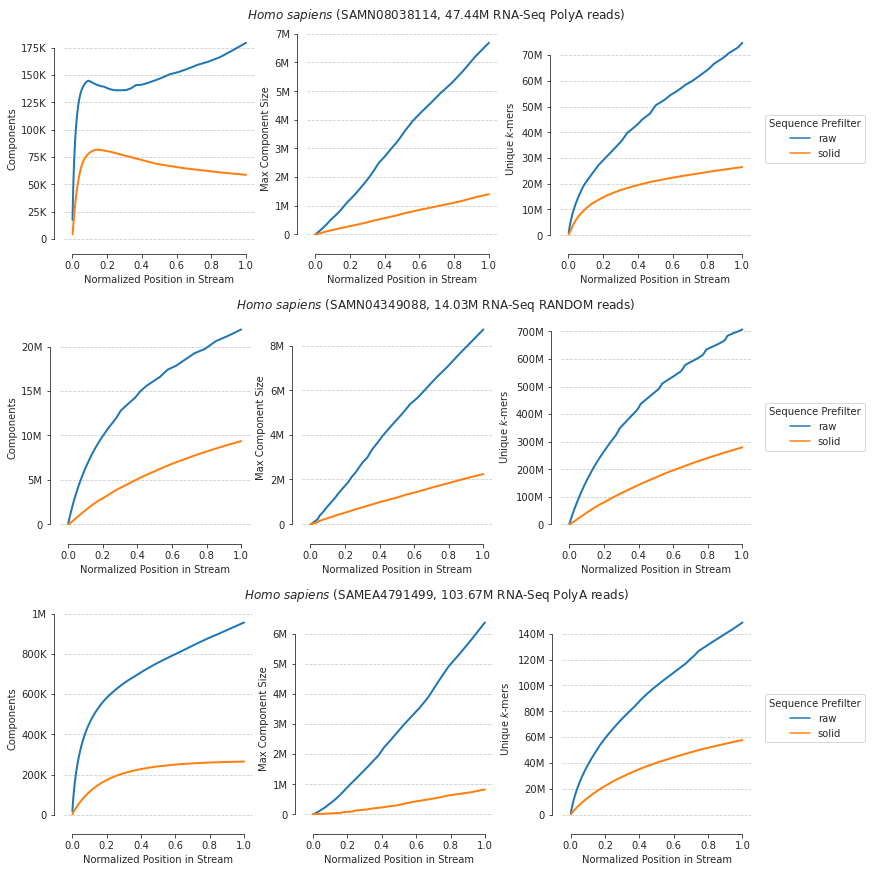

In [76]:
#samples = meta.sort_values('scientific_name').index
samples = meta.query('scientific_name == "Homo sapiens"').index

with sns.axes_style("ticks"), \
     SubFigureManager(show=True, 
                      figsize=(12,len(samples) * 4),  
                      subfigs='row',
                      nrows=len(samples), 
                      ncols=3) as (fig, subfigs, subaxes):
    
    from matplotlib.lines import Line2D
    
    for row, (sample_name, subfig, subax) in enumerate(zip(samples, subfigs, subaxes)):
        lax, cax, rax = subax
        subfig.suptitle(sample_desc(sample_name, meta, n_reads=mdf['seq_t'].max()))

        df = prefilter_comps_df.query(f'sample_name == "{sample_name}"')
        mdf = prefilter_metrics_df.query(f'sample_name == "{sample_name}"')
        
        sns.lineplot(data=df, x='t_norm', y='n_components', hue='prefilter', legend=False, lw=2, ax=lax)
        lax.set_ylabel('Components')
        lax.set_xlabel('Normalized Position in Stream')

        sns.lineplot(data=df, x='t_norm', y='max', hue='prefilter', legend=False, lw=2, ax=cax)
        cax.set_ylabel('Max Component Size')
        cax.set_xlabel('Normalized Position in Stream')
        
        sns.lineplot(data=mdf, x='t_norm', y='n_unique_kmers', hue='prefilter', lw=2, ax=rax)
        rax.set_ylabel('Unique $k$-mers')
        rax.set_xlabel('Normalized Position in Stream')
        
        rax.legend(bbox_to_anchor=(1.05, .5), loc='center left', title='Sequence Prefilter')

        despine(lax, cax, rax)
        lax.yaxis.set_major_formatter(numerize_fmtr)
        cax.yaxis.set_major_formatter(numerize_fmtr)
        rax.yaxis.set_major_formatter(numerize_fmtr)